In [ ]:
!pip install google-cloud-vision

In [3]:
import io
import json
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import google.auth
from google.cloud import vision
from google.oauth2 import service_account

In [4]:
#
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"../cred/dts-10-ds-32748754226a.json"

#
creds, proj = google.auth.default()
print("GOOGLE_APPLICATION_CREDENTIALS =", os.environ.get("GOOGLE_APPLICATION_CREDENTIALS"))
print("Projeto detectado pelas credenciais:", proj)

# Inicializar cliente Vision
client = vision.ImageAnnotatorClient()

GOOGLE_APPLICATION_CREDENTIALS = ../cred/dts-10-ds-32748754226a.json
Projeto detectado pelas credenciais: dts-10-ds


In [ ]:
# Caminhos de entrada

# Precisar alterar o caminho de entrada dos documentos aqui !
doc_path = Path(r"G:\Meu Drive\AI_data_lab\Cursos_ml_AI\Fiap\Cognitive Environments\trabalho_final\data\002.JPG")
comp_path = Path(r"G:\Meu Drive\AI_data_lab\Cursos_ml_AI\Fiap\Cognitive Environments\trabalho_final\data\003.jpg")
selfie_path = Path(r"G:\Meu Drive\AI_data_lab\Cursos_ml_AI\Fiap\Cognitive Environments\trabalho_final\data\002.jpg")

In [6]:
# Caminho de saída

# Precisar alterar o caminho de entrada dos documentos aqui !
out_dir = Path(r"G:\Meu Drive\AI_data_lab\Cursos_ml_AI\Fiap\Cognitive Environments\trabalho_final\outputs")
out_dir.mkdir(parents=True, exist_ok=True)
out_file = out_dir / "results.json"

In [7]:
# FUNÇÕES 
def extract_text(image_path: str) -> str:
    # Extrai texto de uma imagem usando OCR da Google Vision API
    with io.open(image_path, "rb") as image_file:
        content = image_file.read()
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations

    if response.error.message:
        raise Exception(response.error.message)

    return texts[0].description if texts else ""


def compare_faces(img1_path: str, img2_path: str, threshold: float = 0.7):
    
    # Compara duas imagens usando histograma (simples)
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)

    if img1 is None or img2 is None:
        raise FileNotFoundError("Uma das imagens não pôde ser carregada.")

    # Calcula histogramas
    hist1 = cv2.calcHist([img1], [0], None, [256], [0, 256])
    hist2 = cv2.calcHist([img2], [0], None, [256], [0, 256])

    # Compara os histogramas
    score = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)

    # Retorna se passou o threshold e o score
    return score >= threshold, float(score)


def extract_face_and_save(image_path: str, output_file: str):
    
    # Extrai a região de rosto de um documento e salva como imagem
    with io.open(image_path, "rb") as image_file:
        content = image_file.read()
    image = vision.Image(content=content)

    # Detectar rostos usando Vision API
    response = client.face_detection(image=image)
    faces = response.face_annotations

    if not faces:
        print("⚠ Nenhum rosto detectado na imagem.")
        return None

    # Abrir imagem original com OpenCV
    img_cv = cv2.imread(image_path)
    h, w, _ = img_cv.shape

    for i, face in enumerate(faces):
        # Pega as coordenadas do bounding box
        x_min = min([v.x for v in face.bounding_poly.vertices])
        x_max = max([v.x for v in face.bounding_poly.vertices])
        y_min = min([v.y for v in face.bounding_poly.vertices])
        y_max = max([v.y for v in face.bounding_poly.vertices])

        # Garante que os limites não ultrapassem a imagem
        x_min, y_min = max(x_min, 0), max(y_min, 0)
        x_max, y_max = min(x_max, w), min(y_max, h)

        # Recorta o rosto
        face_crop = img_cv[y_min:y_max, x_min:x_max]

        # Salva a imagem do rosto
        face_file = Path(output_file).with_name(f"face_{i+1}.jpg")
        cv2.imwrite(str(face_file), face_crop)
        print(f" Rosto {i+1} salvo em: {face_file}")

    return True

In [8]:
# PIPELINE PRINCIPAL 
if __name__ == "__main__":

    # Verifica se os arquivos de entrada existem
    for p in [doc_path, comp_path, selfie_path]:
        if not p.exists():
            raise FileNotFoundError(f"Arquivo não encontrado: {p}")

    # OCR no documento
    print("Iniciando OCR do documento...")
    documento_texto = extract_text(str(doc_path))

    # OCR no comprovante
    print(" Iniciando OCR do comprovante...")
    comprovante_texto = extract_text(str(comp_path))

    # Comparação facial
    print(" Comparando selfie com documento...")
    match, score = compare_faces(str(selfie_path), str(doc_path))

    # Resultado consolidado
    resultado = {
        "documento_extraido": documento_texto,
        "comprovante_extraido": comprovante_texto,
        "face_match": match,
        "similaridade": score
    }

    # Salvar JSON final
    with out_file.open("w", encoding="utf-8") as f:
        json.dump(resultado, f, ensure_ascii=False, indent=4)

    print(f" Pipeline concluído. Resultados salvos em {out_file.resolve()}")

    # Extração e salvamento do rosto do documento
    extract_face_and_save(str(doc_path), str(out_dir / "face_from_doc.jpg"))

Iniciando OCR do documento...
 Iniciando OCR do comprovante...
 Comparando selfie com documento...
 Pipeline concluído. Resultados salvos em G:\Meu Drive\AI_data_lab\Cursos_ml_AI\Fiap\Cognitive Environments\trabalho_final\outputs\results.json
 Rosto 1 salvo em: G:\Meu Drive\AI_data_lab\Cursos_ml_AI\Fiap\Cognitive Environments\trabalho_final\outputs\face_1.jpg


In [12]:
with open(out_file, "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame([data])

# Converter resultado em DataFrame
df = pd.DataFrame([resultado])

# Salvar em CSV
csv_path = out_dir / "results.csv"
df.to_csv(csv_path, index=False, encoding="utf-8-sig")

print(f" Resultados salvos em CSV: {csv_path.resolve()}")

# Mostrar o texto sem \n (tudo em uma linha)
df["documento_extraido"] = df["documento_extraido"].str.replace("\n", " ")
df["documento_extraido"].iloc[0]

 Resultados salvos em CSV: G:\Meu Drive\AI_data_lab\Cursos_ml_AI\Fiap\Cognitive Environments\trabalho_final\outputs\results.csv


'TODO O TERRITORIO NACIONAL 000000 REPUBLICA FEDERATIVA DO BRASIL MINISTERIO DA INFRAESTRUTURA SECRETARIA NACIONAL DE TRANSITO BR CARTEIRA NACIONAL DE HABILITAÇÃO/DRIVER LICENSE/PERMISO DE CONDUCCIÓN 2e1 NOME E SOBRENOME NOME SOCIAL TESTE CENTO E DEZ 3 DATA, LOCAL E UP DE NASCIMENTO 19/09/1981 SAO PAULO/SP 1 HABILITAÇÃO 24/05/2022 4a DATA EMISSÃO 24/05/2022 4b VALIDADE ACC 23/05/2023 P 4c DOC IDENTIDADE/ORG EMISSOR/UF 513584349 SSPSP 4d CPF 076.763.758-51 NACIONALIDADE BRASILEIRO FILIAÇÃO PAI DO TESTE HCAB DEZ 5 N° REGISTRO 9 CAT. HAB 00002944662 B'

In [13]:
# Quebrar em múltiplas linhas para leitura
df["documento_extraido"].iloc[0].split("\n")

['TODO O TERRITORIO NACIONAL 000000 REPUBLICA FEDERATIVA DO BRASIL MINISTERIO DA INFRAESTRUTURA SECRETARIA NACIONAL DE TRANSITO BR CARTEIRA NACIONAL DE HABILITAÇÃO/DRIVER LICENSE/PERMISO DE CONDUCCIÓN 2e1 NOME E SOBRENOME NOME SOCIAL TESTE CENTO E DEZ 3 DATA, LOCAL E UP DE NASCIMENTO 19/09/1981 SAO PAULO/SP 1 HABILITAÇÃO 24/05/2022 4a DATA EMISSÃO 24/05/2022 4b VALIDADE ACC 23/05/2023 P 4c DOC IDENTIDADE/ORG EMISSOR/UF 513584349 SSPSP 4d CPF 076.763.758-51 NACIONALIDADE BRASILEIRO FILIAÇÃO PAI DO TESTE HCAB DEZ 5 N° REGISTRO 9 CAT. HAB 00002944662 B']

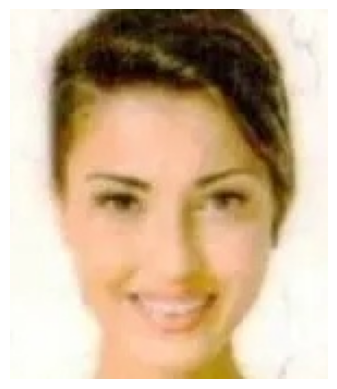

In [14]:
# Caminho da imagem salva
face_img_path = out_dir / "face_1.jpg"

# Carregar a imagem
img = cv2.imread(str(face_img_path))

# Converter de BGR (OpenCV) para RGB (matplotlib)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Exibir
plt.imshow(img_rgb)
plt.axis("off")  # remove os eixos
plt.show()